# Demo of USGS-MAP-gwmodels
This page demonstrates some of the core features of USGS-MAP-gwmodel obs, applied to the Mississippi Delta inset model area. Specifically:

* setup of model layering and property zones by combining voxel-based hydrogeologic facies derived from an airborne electromagnetic (AEM) survey (Burton and others, 2020) with traditional raster surfaces denoting hydrogeologic contacts (Hart and others, 2008)
* culling of NetCDF-based infiltration data (Westenbroek and others, 2020) to the model area, and aggregation to monthly values
* preprocessing of streamflow timeseries for use as specified inflows to the SFR package, or streamflow observations
* preprocessing of head observations
* preprocessing of water use data, including:
    * estimates of agricultural water use (Wilson, 2020)
    * non-agricultulral water use data from the USGS

[Cited References](https://aleaf.github.io/usgs-map-gwmodels/references.html)

In [1]:
%%capture
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
from mfsetup.grid import MFsetupGrid

## Define some global inputs

In [2]:
test_data_path = Path('../mapgwm/tests/data')
output_folder = Path('output')
output_folder.mkdir(exist_ok=True)  # make the output folder if it doesn't exist

# ms delta geographic extent
delta_extent = test_data_path / 'extents/ms_delta.shp'

# simulation start date
start_date='1998-04-01'

# model grid for the MS Delta inset model
ncol=270
nrow=605
dxy=500.
delr = np.ones(ncol) * dxy
delc = np.ones(nrow) * dxy
delta_inset_model_grid = MFsetupGrid(delc, delr, top=None, botm=None,
                                     lenuni=2, epsg=5070,
                                     xoff=434955, yoff=1040285, angrot=0.0)

# shapefile with polygons to group observations by geographic area
geographic_groups = [test_data_path / 'extents/CompositeHydrographArea.shp',
                     test_data_path / 'extents/MAP_generalized_regions.shp'
                     ]

## Set up the model layering and property zones
from AEM-based voxel data and raster surfaces of hydrogeologic contacts

In [3]:
# mean dem values for each 1 km gridcell, elevation units of feet
dem_means_raster = test_data_path / 'rasters/dem_mean_elevs_1000.tif'

# AEM electrical resistivity-based facies classes from tempest and resolve surveys
# (All facies classes version)
facies_classes_netcdf = test_data_path / 'netcdf/RSTM_res_fac_depth_15m.nc'

# Original MERAS framework (1 mi resolution), elevation units of feet
framework_rasters = [
    test_data_path / 'rasters/vkbg_surf.tif',  # Vicksburg-Jackson Group (top)
    test_data_path / 'rasters/ucaq_surf.tif',  # Upper Claiborne aquifer (top)
    test_data_path / 'rasters/mccu_surf.tif',  # Middle Claiborne confining unit (t
    test_data_path / 'rasters/mcaq_surf.tif',  # Middle Claiborne aquifer (top)
    test_data_path / 'rasters/lccu_surf.tif',  # Lower Claiborne confining unit (to
    test_data_path / 'rasters/lcaq_surf.tif',  # Lower Claiborne aquifer (top)
    test_data_path / 'rasters/mwaq_surf.tif',  # Middle Wilcox aquifer (top)
    test_data_path / 'rasters/lwaq_surf.tif',  # Lower Wilcox aquifer (top)
    test_data_path / 'rasters/mdwy_surf.tif',  # Midway confining unit (top)
]
framework_unit_names = [
    'Undifferentiated sediments\nabove the Vicksburg',
    'Vicksburg-Jackson Group',
    'Upper Claiborne aquifer',
    'Middle Claiborne confining unit',
    'Middle Claiborne aquifer',
    'Lower Claiborne confining unit',
    'Lower Claiborne aquifer',
    'Middle Wilcox aquifer',
    'Lower Wilcox aquifer'
]


In [4]:
from mapgwm.framework import setup_model_layers, plot_slice

layers, zone_array = setup_model_layers(dem_means_raster,
                                        facies_classes_netcdf,
                                        framework_rasters,
                                        delta_inset_model_grid,
                                        facies_class_variable='fac_a',  # variable in facies_classes_netcdf with facies zones
                                        facies_zedge_variable='zb',
                                        dem_elevation_units='feet',
                                        framework_raster_elevation_units='feet',
                                        model_length_units='meters', output_folder=output_folder,
                                        framework_unit_names=framework_unit_names)

reading data from ../mapgwm/tests/data/rasters/dem_mean_elevs_1000.tif...
finished in 0.05s
reading data from ../mapgwm/tests/data/rasters/vkbg_surf.tif...
finished in 0.02s
reading data from ../mapgwm/tests/data/rasters/ucaq_surf.tif...
finished in 0.02s
reading data from ../mapgwm/tests/data/rasters/mccu_surf.tif...
finished in 0.03s
reading data from ../mapgwm/tests/data/rasters/mcaq_surf.tif...
finished in 0.02s
reading data from ../mapgwm/tests/data/rasters/lccu_surf.tif...
finished in 0.02s
reading data from ../mapgwm/tests/data/rasters/lcaq_surf.tif...
finished in 0.03s
reading data from ../mapgwm/tests/data/rasters/mwaq_surf.tif...
finished in 0.02s
reading data from ../mapgwm/tests/data/rasters/lwaq_surf.tif...
finished in 0.03s
reading data from ../mapgwm/tests/data/rasters/mdwy_surf.tif...
finished in 0.03s
computing cell thicknesses...
finished in 9.21s

computing cell thicknesses...
finished in 18.28s

wrote output/botm_array/model_top.tif
wrote output/botm_array/botm0.tif

### Plot a cross section slice

In [5]:
framework_unit_labels = dict(zip(range(13, 32), framework_unit_names))

<AxesSubplot:title={'center':'Row 100'}, xlabel='Column in model', ylabel='Elevation, in meters'>

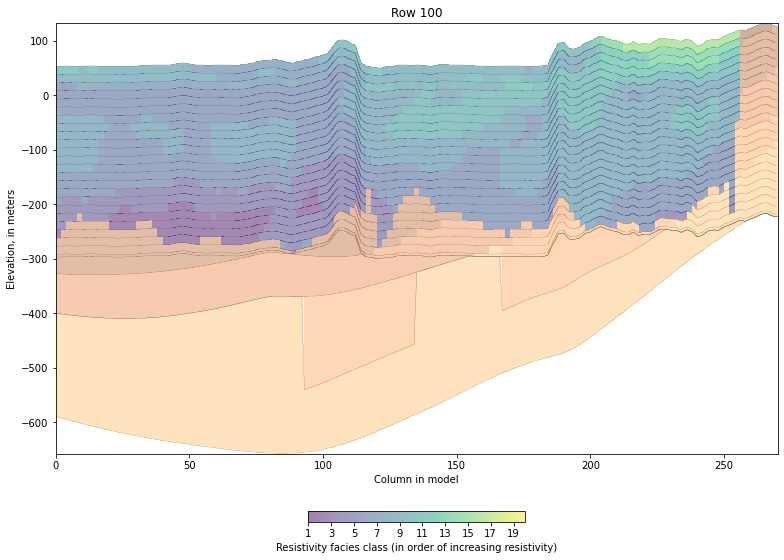

In [6]:
plot_slice(layers, property_data=zone_array,
           row=100, column=slice(None),
           voxel_start_layer=0, voxel_zones=np.arange(1, 21), cmap='copper',
           voxel_cmap='viridis', unit_labels=framework_unit_labels)

## Preprocess recharge
Chop the SWB source data down to the model area and aggregate daily values to monthly means

In [7]:
from mapgwm.swb import get_monthly_means

data_file = test_data_path / 'swb/delta_swb_summer2018.nc'

# output
outputfile = output_folder / 'swb_monthly_means.nc'

# get the monthly means
get_monthly_means(data_file, outfile=outputfile,
                  filter=delta_inset_model_grid.bounds, check_results=True)

opening ../mapgwm/tests/data/swb/delta_swb_summer2018.nc...
culling to bounding box: (434955.0, 1040285.0, 569955.0, 1342785.0)
Aggregating to monthly values...
wrote output/swb_monthly_means.nc
took 0.35s

checking compressed file
finished in 0.37s



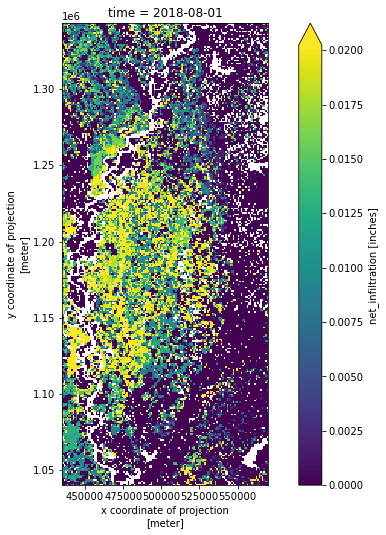

In [8]:
with xr.open_dataset(outputfile) as ds:
    fig, ax = plt.subplots(figsize=(11, 8.5))
    ds['net_infiltration'].sel(time='2018-08').plot(ax=ax, vmax=ds['net_infiltration'].quantile(0.95))
    ax.set_aspect(1)

## Preprocess streamflow data for specified inflows to the SFR package

In [9]:
from mapgwm.obs import preprocess_obs

streamflow_data_file = test_data_path / 'swflows/13Feb2020_rf_output_with_site_numbers.csv'
streamflow_data = pd.read_csv(streamflow_data_file)

# only include flows that are inflows (exclude observations)
include_line_ids = set(streamflow_data.loc[streamflow_data.group == 'meras-inflows', 'comid'])

outfile = output_folder / 'processed_inflows.csv'

In [10]:
streamflow_data.head()

,site_no,comid,datetime,name,group,X,Y,predicted_bf,predicted_total_flow,category
0,07277700,15251676,2007-02-01,"HICKAHALA CREEK NR SENATOBIA, MS",meras-observations,-89.7839,34.6394,82.1099,107.1910,estimated
1,07277700,15251676,2007-03-01,"HICKAHALA CREEK NR SENATOBIA, MS",meras-observations,-89.7839,34.6394,75.3402,85.2905,estimated
2,07277700,15251676,2007-04-01,"HICKAHALA CREEK NR SENATOBIA, MS",meras-observations,-89.7839,34.6394,46.6768,80.6870,estimated
3,07277700,15251676,2007-05-01,"HICKAHALA CREEK NR SENATOBIA, MS",meras-observations,-89.7839,34.6394,41.8452,49.2666,estimated
4,07277700,15251676,2007-06-01,"HICKAHALA CREEK NR SENATOBIA, MS",meras-observations,-89.7839,34.6394,37.1356,47.5411,estimated


In [11]:
data, metadata = preprocess_obs(streamflow_data, 
                                  data_columns=['predicted_total_flow', 'predicted_bf'],
                                  include_line_ids=include_line_ids,
                                  start_date=start_date,
                                  datetime_col='datetime', 
                                  site_no_col='site_no',
                                  line_id_col='comid',
                                  x_coord_col='X',
                                  y_coord_col='Y',
                                  outfile=outfile
                                  )

grouping observations by geographic regions...
writing output/processed_inflows_info.shp... Done
writing output/processed_inflows_info.csv
writing output/processed_inflows.csv


In [12]:
data.head()

,site_no,line_id,datetime,obsprefix,predicted_total_flow,predicted_bf,category
datetime,,,,,,,
2007-02-01,none,19274790,2007-02-01,none-flow,5.175779e+06,4.458664e+06,measured
2007-03-01,none,19274790,2007-03-01,none-flow,2.497954e+06,1.873441e+06,measured
2007-04-01,none,19274790,2007-04-01,none-flow,3.820059e+06,2.017639e+06,measured
2007-05-01,none,19274790,2007-05-01,none-flow,2.154971e+06,1.052037e+06,measured
2007-06-01,none,19274790,2007-06-01,none-flow,1.437397e+06,5.956531e+05,measured


In [13]:
metadata.head()

,start_dt,site_no,end_dt,n,x,y,line_id,name,geometry,obsprefix,group
site_no,,,,,,,,,,,
none,2007-02-01,none,2018-12-01,143,438600.380812,1.105540e+06,19274790,Tensas River,POINT (438600.38081158145 1105539.758365622),none-flow,fluxes


## Preprocess streamflow data for SFR package observations
* Unlike the inflows, which are referenced by NHDPlus COMID, these all have site numbers
* Additionally, we want to fill gaps in measured flow data with statistical estimates
* The ``data`` DataFrame outputs have the time series; 
* The ``metadata`` DataFrame outputs have site information that can be input to **``modflow-setup``** to set up the observation input for MODFLOW-6.

In [14]:
# only include flows that are inflows (exclude observations)
include_sites = set(streamflow_data.loc[streamflow_data.group == 'meras-observations', 'site_no'])

outfile = output_folder / 'processed_flow_obs.csv'

# rename these columns, if present
column_renames = {'predicted_total_flow': 'qtotal_m3d',
                  'predicted_bf': 'qbase_m3d',
                  'qbase_cfs': 'qbase_m3d',
                  'q_cfs': 'qtotal_m3d',
                  'station_nm': 'name'}

### preprocess the statistical estimates

In [15]:
est_data, est_metadata = preprocess_obs(streamflow_data, data_columns=['predicted_total_flow', 'predicted_bf'],
                                          include_sites=include_sites,
                                          start_date=start_date,
                                          active_area=delta_extent,
                                          datetime_col='datetime', 
                                          site_no_col='site_no',
                                          line_id_col='comid',
                                          x_coord_col='X',
                                          y_coord_col='Y',
                                          geographic_groups=geographic_groups,
                                          geographic_groups_col='obsgroup',
                                          qualifier_column='category',
                                          source_crs=4269,
                                          dest_crs=5070,
                                          source_length_units='ft',
                                          source_time_units='s',
                                          dest_length_units='m',
                                          dest_time_units='d',
                                          column_renames=column_renames,
                                          outfile=None
                                          )


reading ../mapgwm/tests/data/extents/ms_delta.shp...
--> building dataframe... (may take a while for large shapefiles)
Culling 7 sites outside of the model area defined by ['../mapgwm/tests/data/extents/ms_delta.shp'].
grouping observations by geographic regions...

reading ../mapgwm/tests/data/extents/MAP_generalized_regions.shp...
--> building dataframe... (may take a while for large shapefiles)

reading ../mapgwm/tests/data/extents/CompositeHydrographArea.shp...
--> building dataframe... (may take a while for large shapefiles)
atchafalaya: 0 obs (0.0%)
boeuf: 0 obs (0.0%)
delta: 9 obs (100.0%)
plains: 0 obs (0.0%)
gp: 0 obs (0.0%)
stfrancis: 0 obs (0.0%)
cache: 0 obs (0.0%)
delta_cha: 0 obs (0.0%)


In [16]:
est_data.head()

,site_no,line_id,datetime,obsprefix,qtotal_m3d,qbase_m3d,category
datetime,,,,,,,
2007-02-01,07288847,17929890,2007-02-01,07288847-flow,659171.062935,564867.808532,estimated
2007-03-01,07288847,17929890,2007-03-01,07288847-flow,316339.771464,278767.710811,estimated
2007-04-01,07288847,17929890,2007-04-01,07288847-flow,328301.079306,179244.687481,estimated
2007-05-01,07288847,17929890,2007-05-01,07288847-flow,632789.638827,216849.532247,estimated
2007-06-01,07288847,17929890,2007-06-01,07288847-flow,250184.368712,130957.604569,estimated


In [17]:
est_metadata.head()

,start_dt,site_no,end_dt,n,x,y,line_id,name,geometry,obsprefix,group,geo_group
site_no,,,,,,,,,,,,
07288000,2007-02-01,07288000,2018-12-01,143,496047.363537,1.262247e+06,17951955,Big Sunflower River,POINT (496047.3635373298 1262247.2944090604),07288000-flow,fluxes,delta
07288280,2007-02-01,07288280,2018-12-01,143,489208.729363,1.239410e+06,17958105,"BIG SUNFLOWER RIVER NR MERIGOLD, MS",POINT (489208.7293628419 1239410.0314052303),07288280-flow,fluxes,delta
07288555,2007-02-01,07288555,2018-12-01,143,509254.529536,1.233598e+06,17958153,"QUIVER RIVER SOUTHEAST RULEVILLE, MS",POINT (509254.5295362755 1233597.9342500775),07288555-flow,fluxes,delta
07288650,2007-02-01,07288650,2018-12-01,143,472484.774612,1.196944e+06,17963095,"BOGUE PHALIA NR LELAND, MS",POINT (472484.77461178595 1196943.873882911),07288650-flow,fluxes,delta
07288700,2007-02-01,07288700,2018-12-01,143,492594.661169,1.195806e+06,17970237,Big Sunflower River,POINT (492594.66116927133 1195806.1680232398),07288700-flow,fluxes,delta


### preprocess the measured values

In [18]:
nwis_streamflow_data = test_data_path / 'swflows/nwis_dvs.csv'
nwis_streamflow_metadata = test_data_path / 'swflows/nwis_dv_sites.csv'

meas_data, meas_metadata = preprocess_obs(nwis_streamflow_data, nwis_streamflow_metadata,
                                            data_columns=['q_cfs', 'qbase_cfs'],
                                            include_sites=include_sites,
                                            start_date=start_date,
                                            active_area=delta_extent,
                                            datetime_col='datetime', 
                                            site_no_col='site_no',
                                            line_id_col='comid',
                                            x_coord_col='dec_long_va',
                                            y_coord_col='dec_lat_va',
                                            geographic_groups=geographic_groups,
                                            geographic_groups_col='obsgroup',
                                            source_crs=4269,
                                            dest_crs=5070,
                                            source_length_units='ft',
                                            source_time_units='s',
                                            dest_length_units='m',
                                            dest_time_units='d',
                                            column_renames=column_renames,
                                            outfile=None
                                            )


reading ../mapgwm/tests/data/extents/ms_delta.shp...
--> building dataframe... (may take a while for large shapefiles)
Culling 40 sites outside of the model area defined by ['../mapgwm/tests/data/extents/ms_delta.shp'].
grouping observations by geographic regions...

reading ../mapgwm/tests/data/extents/MAP_generalized_regions.shp...
--> building dataframe... (may take a while for large shapefiles)

reading ../mapgwm/tests/data/extents/CompositeHydrographArea.shp...
--> building dataframe... (may take a while for large shapefiles)
atchafalaya: 0 obs (0.0%)
boeuf: 0 obs (0.0%)
delta: 8 obs (100.0%)
plains: 0 obs (0.0%)
gp: 0 obs (0.0%)
stfrancis: 0 obs (0.0%)
cache: 0 obs (0.0%)
delta_cha: 0 obs (0.0%)


In [19]:
meas_data.head()

,site_no,datetime,obsprefix,qtotal_m3d,qbase_m3d,category
datetime,,,,,,
2008-01-20,07280400,2008-01-20,07280400-flow,93459.185840,93459.185840,measured
2008-01-21,07280400,2008-01-21,07280400-flow,90278.637631,90278.637631,measured
2008-01-22,07280400,2008-01-22,07280400-flow,153155.629151,92176.690939,measured
2008-01-23,07280400,2008-01-23,07280400-flow,214809.332899,94114.868086,measured
2008-01-24,07280400,2008-01-24,07280400-flow,144347.957187,96093.658387,measured


In [20]:
meas_metadata.head()

,site_no,name,site_tp_cd,y,x,coord_meth_cd,coord_acy_cd,coord_datum_cd,dec_coord_datum_cd,district_cd,...,sv_begin_date,sv_end_date,sv_count_nu,geometry,start_dt,end_dt,n,obsprefix,group,geo_group
site_no,,,,,,,,,,,,,,,,,,,,,
07280400,07280400,"TILLATOBA CREEK AT CHARLESTON, MS",ST,1.231964e+06,543849.348583,G,5,NAD83,NAD83,28,...,1976-08-18,2015-09-08,132.0,POINT (543849.3485826917 1231964.1991941927),2008-01-20,2009-09-22,612.0,07280400-flow,fluxes,delta
07288000,07288000,"BIG SUNFLOWER RIVER AT CLARKSDALE, MS",ST,1.251190e+06,495901.606421,M,F,NAD27,NAD83,28,...,1995-05-18,2020-08-11,29.0,POINT (495901.606420672 1251190.4812774335),2017-10-02,2020-09-20,884.0,07288000-flow,fluxes,delta
07288280,07288280,"BIG SUNFLOWER RIVER NR MERIGOLD, MS",ST,1.209990e+06,489521.298812,G,5,NAD83,NAD83,28,...,1992-10-06,2020-06-30,266.0,POINT (489521.2988124544 1209990.1526558788),2008-01-08,2020-09-18,4633.0,07288280-flow,fluxes,delta
07288650,07288650,"BOGUE PHALIA NR LELAND, MS",ST,1.160478e+06,475848.051335,G,5,NAD83,NAD83,28,...,1953-11-10,2020-06-30,233.0,POINT (475848.05133488495 1160478.1083699472),2008-01-08,2020-09-22,4592.0,07288650-flow,fluxes,delta
07288700,07288700,"BIG SUNFLOWER RIVER NR ANGUILLA, MS",ST,1.113472e+06,484902.570251,M,M,NAD27,NAD83,28,...,1980-07-23,2011-02-15,35.0,POINT (484902.5702511699 1113472.33857191),NaN,NaN,NaN,07288700-flow,fluxes,delta


### Combine the measured and estimated observations into one dataset
* Resample both datasets to a continuous monthly frequency (labeled with the start date of each month)
* Prioritize measured data when available; fill gaps with statistical estimates
* Once the model has been run, the observation output from the model can be fed to **``modflow-obs``** along with the  ``combined_obs`` timeseries (below), to set up **``PEST``** observations, or create observation output to be read by **``PEST``**.

In [21]:
from mapgwm.swflows import combine_measured_estimated_values

combined_obs = combine_measured_estimated_values(meas_data, est_data,
                                                 measured_values_data_col='qbase_m3d', 
                                                 estimated_values_data_col='qbase_m3d',
                                                 resample_freq='MS', how='mean')

In [22]:
combined_obs.head()

,site_no,line_id,datetime,obsprefix,category,est_qtotal_m3d,est_qbase_m3d,meas_qtotal_m3d,meas_qbase_m3d,obsval
0,07280400,NaN,2008-01-01,07280400-flow,measured,NaN,NaN,2.219044e+05,99816.041527,99816.041527
1,07280400,NaN,2008-02-01,07280400-flow,measured,NaN,NaN,3.343203e+05,130662.640359,130662.640359
2,07280400,NaN,2008-03-01,07280400-flow,measured,NaN,NaN,5.228016e+05,112159.341365,112159.341365
3,07280400,NaN,2008-04-01,07280400-flow,measured,NaN,NaN,1.080310e+06,197271.496485,197271.496485
4,07280400,NaN,2008-05-01,07280400-flow,measured,NaN,NaN,6.351547e+05,165388.483203,165388.483203


### plot data for a site of interest

Text(0, 0.5, 'Flow, in m$^3$/day')

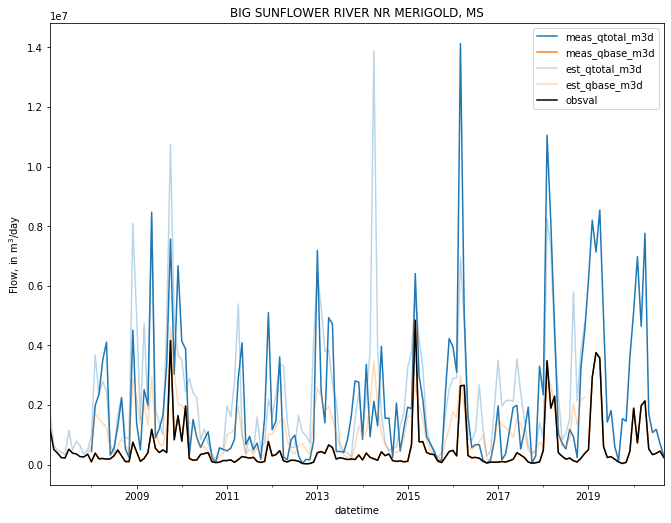

In [23]:
site_no = '07288280'
site_data = combined_obs.loc[combined_obs.site_no == site_no].copy()
site_data.index = site_data.datetime

fig, ax = plt.subplots(figsize=(11, 8.5))
ax = site_data[['meas_qtotal_m3d','meas_qbase_m3d']].plot(ax=ax)
ax = site_data[['est_qtotal_m3d','est_qbase_m3d']].plot(alpha=0.3, ax=ax, color=['C0', 'C1'])
site_data.obsval.plot(ax=ax, c='k')
ax.set_title(meas_metadata.loc[site_no, 'name'])
ax.legend()
ax.set_ylabel('Flow, in m$^3$/day')

## Preprocess head observations
Preprocess head observation data, from the [visGWDB program](https://doi.org/10.5066/P9W004O6)
* reproject to the model CRS
* cull data to a `start_date` and optionally, a polygon or set of polygons defining the model area
* length units are converted to those of the groundwater model. Open intervals for the wells are
  converted from depths to elevations
* missing open intervals are filled based on well bottom depths (if availabile) and the median open
  interval length for the dataset.
* Wells are categorized based on the quality of the open interval information (see the documentation
  for :func:`mapgwm.headobs.fill_well_open_intervals`).
* Prefixes for observation names (with an optional length limit) that identify the location are generated
* Similar to with flux observations, assign preliminary observation groups based on geographic areas defined by the
* The ``data`` DataFrame outputs have the time series; 
* The ``metadata`` DataFrame outputs have site information that can be input to **``modflow-setup``** to set up the observation input for MODFLOW-6.
* Once the model has been run, the observation output from the model can be fed to **``modflow-obs``** along with the  ``data`` timeseries (below), to set up **``PEST``** observations, or create observation output to be read by **``PEST``**.

In [24]:
from mapgwm.headobs import preprocess_headobs, get_data

data_file = test_data_path / 'headobs/GW_monthly_stats1990-01-01_2019-12-31.txt'
metadata_file = test_data_path / 'headobs/GW_monthly_meta1990-01-01_2019-12-31.txt'

# output
outputfile = output_folder / 'preprocessed_monthly_headobs.csv'

In [25]:
# read the data
data_orig, metadata_orig = get_data(data_file, metadata_file)

# do the preprocessing
data, metadata = preprocess_headobs(data_orig, metadata_orig,
                                    head_data_columns=['head', 'last_head'],
                                    data_length_units='feet',
                                    active_area=delta_extent,
                                    source_crs=4269, dest_crs=5070,
                                    start_date=start_date,
                                    geographic_groups=geographic_groups,
                                    geographic_groups_col='obsgroup',
                                    outfile=outputfile)

starting with 71 measurements at 10 unique wells
culling 13 measurements from 2 sites that are prior to start date of 1998-04-01

reading ../mapgwm/tests/data/extents/ms_delta.shp...
--> building dataframe... (may take a while for large shapefiles)
Culling 2 sites outside of the model area defined by ['../mapgwm/tests/data/extents/ms_delta.shp'].
50% of wells (n=4) have incomplete open interval information. Filling screen bottoms with well bottoms where available, and estimating screen tops from median open interval length.
12% of wells (n=1) still missing open interval information; assigned to category 4.
grouping observations by geographic regions...

reading ../mapgwm/tests/data/extents/MAP_generalized_regions.shp...
--> building dataframe... (may take a while for large shapefiles)

reading ../mapgwm/tests/data/extents/CompositeHydrographArea.shp...
--> building dataframe... (may take a while for large shapefiles)
atchafalaya: 0 obs (0.0%)
boeuf: 2 obs (25.0%)
delta: 6 obs (75.0%)
p

In [26]:
data.head()

,site_no,datetime,head,last_head,head_std,n,obsprefix
4,USGS:332915091025901,2003-07-01,37.185600,37.185600,NaN,1,USGS:332915091025901
5,USGS:333411090482201,2008-03-01,28.096464,28.096464,NaN,1,USGS:333411090482201
6,USGS:333411090482201,2010-03-01,27.736800,27.736800,NaN,1,USGS:333411090482201
7,USGS:333411090482201,2015-03-01,26.560272,26.560272,NaN,1,USGS:333411090482201
8,USGS:333411090482201,2019-03-01,26.484072,26.484072,NaN,1,USGS:333411090482201


In [27]:
metadata.head()

,head,head_std,last_head,n,datetime,aqfr_cd,nat_aqfr_cd,screen_botm,screen_top,well_depth,...,x,y,geometry,well_botm,category,orig_scbot,orig_sctop,obsprefix,group,geo_group
site_no,,,,,,,,,,,,,,,,,,,,,
USGS:323340091085201,19.50720,NaN,19.50720,1,2011-04-01,112MRVA,N100MSRVVL,-88.177600,-75.985600,115.0,...,452922.427646,1.065894e+06,POINT (452922.42764626874 1065893.7729683416),-88.177600,2,NaN,NaN,USGS:323340091085201,heads,boeuf
USGS:325121091093801,29.87040,NaN,29.87040,1,1999-02-01,112MRVA,N100MSRVVL,-58.605600,-46.413600,90.0,...,450055.327781,1.098664e+06,POINT (450055.32778086985 1098664.3677878508),-58.605600,2,NaN,NaN,USGS:325121091093801,heads,boeuf
USGS:332915091025901,37.18560,NaN,37.18560,1,2003-07-01,112MRVA,N100MSRVVL,6.705600,15.240000,108.0,...,456688.018145,1.169617e+06,POINT (456688.0181453624 1169616.8556726126),-68.376000,3,6.7056,15.24,USGS:332915091025901,heads,delta
USGS:333411090482201,27.60726,NaN,27.60726,40,2008-03-01,112MRVA,N100MSRVVL,-81.262968,-69.070968,120.0,...,478637.876037,1.179983e+06,POINT (478637.87603653426 1179983.3214310212),-81.262968,2,NaN,NaN,USGS:333411090482201,heads,delta
USGS:333633090230701,23.77440,NaN,23.77440,1,2002-04-01,112MRVA,N100MSRVVL,3.048000,15.240000,115.0,...,517102.401121,1.186603e+06,POINT (517102.4011205511 1186603.4163717527),-76.900000,3,3.0480,15.24,USGS:333633090230701,heads,delta_cha


## Preprocess ag. water use from the IWUM
* read agricultural water use estimates from the Irrigation Water Use Model (IWUM; Wilson, 2020)
* cull data to the model area
* convert rates from cumulative volumes per time period to cubic meters per day
* assign open intervals based on raster surfaces of the estimated production zone for agricultural groundwater use

In [28]:
from mapgwm.iwum import preprocess_iwum_pumping

iwum_output = test_data_path / 'iwum/irr_wu_1km_1999_to_2017.nc'
production_zone_top_raster = test_data_path / 'iwum/est_prod_zone_top.tif'
production_zone_botm_raster = test_data_path / 'iwum/est_prod_zone_botm.tif'

outfile = output_folder / 'iwum_m3.csv'

In [29]:
ag_wu = preprocess_iwum_pumping(iwum_output,
                                start_date=None,
                                end_date=None,
                                active_area=delta_extent,
                                estimated_production_zone_top=production_zone_top_raster,
                                estimated_production_zone_botm=production_zone_botm_raster,
                                flux_variable='value',
                                nc_crs=5070,
                                nc_length_units='meters',
                                estimated_production_surface_units='meters',
                                model_length_units='meters',
                                outfile=outfile)

reading data from ../mapgwm/tests/data/iwum/est_prod_zone_top.tif...
finished in 0.31s
reading data from ../mapgwm/tests/data/iwum/est_prod_zone_botm.tif...
finished in 0.12s
Reset screen top and bottom to mean elevation at 9 locations where screen top was < screen bottom

reading ../mapgwm/tests/data/extents/ms_delta.shp...
--> building dataframe... (may take a while for large shapefiles)
Culling 14086 sites outside of the model area defined by ['../mapgwm/tests/data/extents/ms_delta.shp'].
wrote output/iwum_m3.csv
wrote output/plots/irr_wu_1km_1999_to_2017.nc_2022-04-21.pdf


In [30]:
ag_wu.head()

,site_no,x,y,screen_top,screen_botm,start_datetime,end_datetime,q
179,iwum_179,477955.0,1041285.0,14.444472,7.388352,2017-06-01,2017-06-30,-2043.222778
314,iwum_314,476955.0,1042285.0,13.722096,6.352032,2017-06-01,2017-06-30,-2093.868652
315,iwum_315,477955.0,1042285.0,14.182344,7.059168,2017-06-01,2017-06-30,-1526.927734
443,iwum_443,469955.0,1043285.0,11.094720,3.331464,2017-06-01,2017-06-30,-1283.890991
444,iwum_444,470955.0,1043285.0,11.436096,3.541776,2017-06-01,2017-06-30,-1245.565308


### Plot average pumping at each location

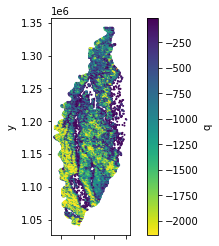

In [31]:
site_means = ag_wu.groupby('site_no').mean()
ax = site_means.plot(kind='scatter', x='x', y='y', c='q', s=1,
                     cmap='viridis_r', vmin=site_means.q.quantile(0.1))
ax.set_aspect(1)

## Preprocess non-ag. water use
Including data from
* the USGS Site-Specific Water Use Database (SWUDS)
* USGS data on water use for thermo-electric power generation


### SWUDs data
* SWUDs data are assumed to come in an Excel spreadsheet, that may have incomplete information on well screen intervals
* similar to other preprocessing methods, the data are reprojected and optionally culled to an area of interest
* if input data do not have information on the well screen intervals, screen tops and bottoms are sampled from raster surfaces bounding estimated production zones; well depth is used to discriminate between zones
* data are resampled to continous monthly values between a specified start and end date- typically bracketing the time range that the pumping should be simulated in the model

In [32]:
from mapgwm.swuds import preprocess_swuds

swuds_input = test_data_path / 'swuds/withdrawals_test_dataset.xlsx'
worksheet = 'LMG-withdrawals-2000-2018'
outfile = output_folder / 'preprocessed_swuds_data.csv'

dem = test_data_path / 'rasters/dem_mean_elevs.tif'

# raster defining the tops and bottoms of non-agricultural public supply production intervals
# from Knierem
production_zones = {'mrva': (test_data_path / 'swuds/rasters/pz_MRVA_top.tif',
                             test_data_path / 'swuds/rasters/pz_MRVA_bot.tif',
                             ),
                    'mcaq': (test_data_path / 'swuds/rasters/pz_MCAQP_top.tif',
                             test_data_path / 'swuds/rasters/pz_MCAQP_bot.tif',
                             'feet'),
                    'lcaq': (test_data_path / 'swuds/rasters/pz_LCAQP_top.tif',
                             test_data_path / 'swuds/rasters/pz_LCAQP_bot.tif')
                    }

In [33]:
swuds_results = preprocess_swuds(swuds_input, worksheet,
                                 dem=dem, dem_units='feet',
                                 start_date=None,
                                 end_date=None,
                                 active_area=test_data_path / 'extents/ms_delta.shp',
                                 production_zones=production_zones,
                                 source_crs=4269,
                                 dest_crs=5070,
                                 data_length_units='feet',
                                 data_volume_units='mgal',
                                 model_length_units='meters',
                                 outfile=outfile)


reading ../mapgwm/tests/data/extents/ms_delta.shp...
--> building dataframe... (may take a while for large shapefiles)
Culling 831 sites outside of the model area defined by ['../mapgwm/tests/data/extents/ms_delta.shp'].
reading data from ../mapgwm/tests/data/rasters/dem_mean_elevs.tif...
finished in 0.02s
reading data from ../mapgwm/tests/data/swuds/rasters/pz_MRVA_top.tif...
finished in 0.00s
reading data from ../mapgwm/tests/data/swuds/rasters/pz_MRVA_bot.tif...
finished in 0.00s
reading data from ../mapgwm/tests/data/swuds/rasters/pz_MCAQP_top.tif...
finished in 0.00s
reading data from ../mapgwm/tests/data/swuds/rasters/pz_MCAQP_bot.tif...
finished in 0.00s
reading data from ../mapgwm/tests/data/swuds/rasters/pz_LCAQP_top.tif...
finished in 0.00s
reading data from ../mapgwm/tests/data/swuds/rasters/pz_LCAQP_bot.tif...
finished in 0.00s
processed SWUDS data written to output/preprocessed_swuds_data.csv and in dataframe attribute
writing output/preprocessed_swuds_data.shp... Done


A `mapgwm.swuds.Swuds` object is returned, which has a dataframe attribute:

In [34]:
swuds_results.df.head()

,site_no,q,q_monthly,month,well_elev,depth,screen_botm,screen_top,x,y,start_datetime,geometry
2010-01-01,swuds_322431090530201,-20895.471597,5.52,JAN_VAL,25.908,37.1856,-11.2776,8.7224,478430.626345,1.050261e+06,2010-01-01,POINT (478430.62634453585 1050260.7663818887)
2010-02-01,swuds_322431090530201,-20895.471597,5.52,FEB_VAL,25.908,37.1856,-11.2776,8.7224,478430.626345,1.050261e+06,2010-02-01,POINT (478430.62634453585 1050260.7663818887)
2010-03-01,swuds_322431090530201,-20895.471597,5.52,MAR_VAL,25.908,37.1856,-11.2776,8.7224,478430.626345,1.050261e+06,2010-03-01,POINT (478430.62634453585 1050260.7663818887)
2010-04-01,swuds_322431090530201,-20895.471597,5.52,APR_VAL,25.908,37.1856,-11.2776,8.7224,478430.626345,1.050261e+06,2010-04-01,POINT (478430.62634453585 1050260.7663818887)
2010-05-01,swuds_322431090530201,-20895.471597,5.52,MAY_VAL,25.908,37.1856,-11.2776,8.7224,478430.626345,1.050261e+06,2010-05-01,POINT (478430.62634453585 1050260.7663818887)


## Water use for thermoelectric power generation
* similar to the SWUDs data, data for water use related to TE power generation are assumed to come in a spreadsheet
* however, the column names might different between different datasets. 
* therefore, the first step is to read in the data using a function that harmonizes the column names, and then combine the data using ``DataFrame.append()``:

In [35]:
from mapgwm.te_wateruse import read_te_water_use_spreadsheet, preprocess_te_wateruse

df2010 = read_te_water_use_spreadsheet(test_data_path / 'swuds/2010_Thermo_Model_Estimates.xlsx',
                                       date='2010',
                                       x_coord_col='Longitude, decimal degrees',
                                       y_coord_col='Latitude, decimal degrees',
                                       q_col='USGS-Estimated Annual Withdrawal (Mgal/d)',
                                       site_no_col='PLANT CODE',
                                       site_name_col='PLANT NAME',
                                       source_name_col='NAME OF WATER SOURCE',
                                       source_code_col='USGS WATER SOURCE CODE',
                                       sheet_name='Report_table_UPDATED', skiprows=2)

df2015 = read_te_water_use_spreadsheet(test_data_path / 'swuds/2015_TE_Model_Estimates_lat.long_COMIDs.xlsx',
                                   date='2015',
                                   x_coord_col='LONGITUDE',
                                   y_coord_col='LATITUDE',
                                   q_col='WITHDRAWAL',
                                   site_no_col='EIA_PLANT_ID',
                                   site_name_col='PLANT_NAME',
                                   source_name_col='NAME_OF_WATER_SOURCE',
                                   source_code_col='WATER_SOURCE_CODE',
                                   sheet_name='2015_ANNUAL_WD_CU', skiprows=0)
df = df2010.append(df2015)

We can then run the data through a similar function to that used for SWUDs:

In [36]:
outfile = output_folder / 'preprocessed_te_data.csv'

estimated_production_zone_top = test_data_path / 'swuds/rasters/pz_MCAQP_top.tif'
estimated_production_zone_botm = test_data_path / 'swuds/rasters/pz_MCAQP_bot.tif'

te_results = preprocess_te_wateruse(df, #dem=dem, dem_units='feet',
                                    start_date='2008-01-01',
                                    end_date='2017-12-31',
                                    active_area=test_data_path /'extents/ms_delta.shp',
                                    estimated_production_zone_top=estimated_production_zone_top,
                                    estimated_production_zone_botm=estimated_production_zone_botm,
                                    estimated_production_surface_units='feet',
                                    source_crs=4269,
                                    dest_crs=5070,
                                    data_volume_units='mgal',
                                    model_length_units='meters',
                                    outfile=outfile)


reading ../mapgwm/tests/data/extents/ms_delta.shp...
--> building dataframe... (may take a while for large shapefiles)
Culling 405 sites outside of the model area defined by ['../mapgwm/tests/data/extents/ms_delta.shp'].
reading data from ../mapgwm/tests/data/swuds/rasters/pz_MCAQP_top.tif...
finished in 0.02s
reading data from ../mapgwm/tests/data/swuds/rasters/pz_MCAQP_bot.tif...
finished in 0.02s
wrote output/preprocessed_te_data.csv
writing output/preprocessed_te_data.shp... Done


In [37]:
te_results.head()

,site_no,start_datetime,x,y,screen_top,screen_botm,q,geometry,site_name,source_name
2008-01-01,te_2059,2008-01-01,497139.150871,1.249816e+06,-147.409514,-162.649514,-0.0,POINT (497139.15087110555 1249816.468462982),L L Wilkins,Wells
2008-02-01,te_2059,2008-02-01,497139.150871,1.249816e+06,-147.409514,-162.649514,-0.0,POINT (497139.15087110555 1249816.468462982),L L Wilkins,Wells
2008-03-01,te_2059,2008-03-01,497139.150871,1.249816e+06,-147.409514,-162.649514,-0.0,POINT (497139.15087110555 1249816.468462982),L L Wilkins,Wells
2008-04-01,te_2059,2008-04-01,497139.150871,1.249816e+06,-147.409514,-162.649514,-0.0,POINT (497139.15087110555 1249816.468462982),L L Wilkins,Wells
2008-05-01,te_2059,2008-05-01,497139.150871,1.249816e+06,-147.409514,-162.649514,-0.0,POINT (497139.15087110555 1249816.468462982),L L Wilkins,Wells


### Plot the locations of SWUDs and TE water use

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Pumpage from SWUDs, in m$^3$/day')

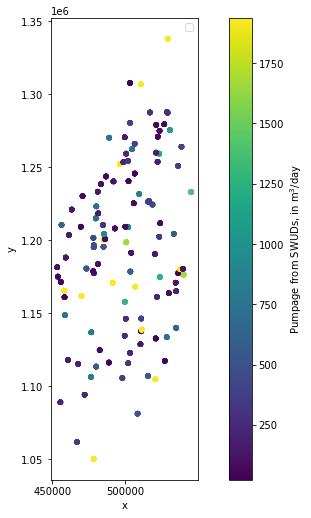

In [38]:
fig, ax = plt.subplots(figsize=(11, 8.5))
ax = swuds_results.df.plot.scatter(x='x', y='y', c=swuds_results.df.q.abs(),
                                   cmap='viridis', #norm=mpl.colors.LogNorm(), 
                                   vmax=swuds_results.df.q.abs().quantile(0.9),
                                   ax=ax)
#te_results.plot.scatter(x='x', y='y', c='r',
#                        ax=ax, label='TE sites')
ax.legend()
ax.set_aspect(1)
cax = fig.get_axes()[1]
#and we can modify it, i.e.:
cax.set_ylabel('Pumpage from SWUDs, in m$^3$/day')